# Bahrain Pre-Season Testing: Test 1 vs Test 2 (2026)

This project analyses long-run pace, single-lap performance, and team mileage across both Bahrain pre-season testing events in 2026. Early-season testing provides the first structured glimpse into competitive order before the championship begins. Unlike race weekends, testing sessions are shaped by unknown fuel loads, engine modes, tyre programs, and experimental setups. As a result, raw lap times alone cannot reliably represent true performance. To address this, the analysis focuses on:
- Compound-normalised long-run pace (to reduce tyre bias)
- Fastest laps by driver (single-lap performance indicator)
- Total team mileage (operational reliability and program completion)

The goal is not to predict championship outcomes, but to provide a structured, data-driven comparison of early competitive signals.

In [22]:
import pandas as pd
import numpy as np
import fastf1
import matplotlib.pyplot as plt
from fastf1.core import Laps

## 1. Get events

In [23]:
# Pull the full 2026 calendar from FastF1
schedule = fastf1.get_event_schedule(2026)

# Filter to testing events only (FastF1 marks them with EventFormat='testing')
testing = schedule[schedule['EventFormat'] == 'testing']
testing

,RoundNumber,Country,Location,OfficialEventName,EventDate,EventName,EventFormat,Session1,Session1Date,Session1DateUtc,...,Session3,Session3Date,Session3DateUtc,Session4,Session4Date,Session4DateUtc,Session5,Session5Date,Session5DateUtc,F1ApiSupport
0,0,Bahrain,Bahrain,FORMULA 1 ARAMCO PRE-SEASON TESTING 1 2026,2026-02-13,Pre-Season Testing,testing,Practice 1,2026-02-11 10:00:00+03:00,2026-02-11 07:00:00,...,Practice 3,2026-02-13 10:00:00+03:00,2026-02-13 07:00:00,None,NaT,NaT,None,NaT,NaT,True
1,0,Bahrain,Bahrain,FORMULA 1 ARAMCO PRE-SEASON TESTING 2 2026,2026-02-20,Pre-Season Testing,testing,Practice 1,2026-02-18 10:00:00+03:00,2026-02-18 07:00:00,...,Practice 3,2026-02-20 10:00:00+03:00,2026-02-20 07:00:00,None,NaT,NaT,None,NaT,NaT,True


Testing runs are not explicitly labelled as “race simulations”.
Here, long runs are approximated as continuous sequences of ≥ min_laps laps within the same:
Session (1/2/3)
- Driver
- Stint
- Compound

Cleaning filters applied:

- accurate timing only (IsAccurate)
- exclude deleted laps
- only laps with a laptime + compound + stint info
- optionally restrict to a track status (default "1" = typical “green” running)

For each long run:
- AvgPace = mean lap time (seconds)
- Degradation = slope of a linear fit across lap number in the run (sec/lap)

In [25]:
def load_testing_laps(year, test_no, sessions=(1,2,3)):
    # Load laps across all testing days/sessions and concatenate into one DataFrame
    laps_all = []
    for s in sessions:
        # FastF1 provides testing sessions as test_no (1 or 2) and session/day (1..3)
        sess = fastf1.get_testing_session(year, test_no, s)
        sess.load()
        
        # Copy laps table (timing data) and tag which testing day it came from
        laps = sess.laps.copy()
        laps["Session"] = s
        laps_all.append(laps)
    return pd.concat(laps_all, ignore_index=True)

def longrun_team_summary(laps_all, min_laps=10, track_status="1"):
    # Filter to "clean" laps:
    # - accurate timestamps
    # - not deleted (e.g., out/in laps or corrupted records)
    # - restrict to a chosen track status (default "1")
    # - require laptime, compound, and stint to exist
    df = laps_all[
        (laps_all["IsAccurate"]) &
        (~laps_all["Deleted"]) &
        (laps_all["TrackStatus"] == track_status) &
        (laps_all["LapTime"].notna()) &
        (laps_all["Compound"].notna()) &
        (laps_all['Compound'] != 'TEST_UNKNOWN') &
        (laps_all["Stint"].notna())
    ].copy()
    
    # Convert timedelta LapTime into numeric seconds for averaging/regression
    df["LapTimeSeconds"] = df["LapTime"].dt.total_seconds()
    
    # Ensure lap index is numeric for detecting continuous sequences
    df["LapNumber"] = df["LapNumber"].astype(int)

    # Build long runs:
    # Within each (session, driver, stint, compound), split whenever lap numbers stop being consecutive.
    # Any continuous chunk with >= min_laps is treated as a "long run".
    long_runs = []
    for (session, driver, stint, compound), g in df.groupby(["Session","Driver","Stint","Compound"]):
        g = g.sort_values("LapNumber").copy()
        run_id = (g["LapNumber"].diff() != 1).cumsum()

        for _, run in g.groupby(run_id):
            if len(run) >= min_laps:
                run = run.copy()
                y = run["LapTimeSeconds"].values
                run["RunLength"] = len(run)
                run["AvgPace"] = y.mean()
                run["Degradation"] = np.polyfit(np.arange(len(y)), y, 1)[0]
                long_runs.append(run)

    race_runs = pd.concat(long_runs, ignore_index=True)

    # Collapse each run into one row so we can aggregate by team/compound
    run_level = (race_runs.groupby(["Team","Driver","Session","Stint","Compound"], as_index=False)
                         .agg(RunLength=("LapTimeSeconds","size"),
                              AvgPace=("LapTimeSeconds","mean"),
                              Degradation=("Degradation","first")))

    #run_level["CompoundRank"] = run_level.groupby("Compound")["AvgPace"].rank(method="average")
    team_compound = (
        run_level
        .groupby(['Team','Compound'], as_index=False)
        .agg(
            TeamCompoundAvg=('AvgPace','mean'),
            TeamCompoundDeg=('Degradation','mean'),
            TeamCompoundRunLen=('RunLength','mean'),
            TeamCompoundRuns=('AvgPace','count')
            )
    )
    # Normalisation step:
    # find the best (fastest) team within each compound, then compute deltas to that baseline
    team_compound['BestInCompound'] = (
        team_compound.groupby('Compound')['TeamCompoundAvg']
        .transform('min')
    )

    team_compound['DeltaToBest'] = (
        team_compound['TeamCompoundAvg'] - team_compound['BestInCompound']
    )

    # Final team summary
    team_summary = (
        team_compound
        .groupby('Team')
        .agg(
            AvgDeltaToBest=('DeltaToBest','mean'),
            Runs=('TeamCompoundRuns','sum'),
            AvgRunLength=('TeamCompoundRunLen','mean')
        )
        .sort_values('AvgDeltaToBest')
        )

    return race_runs, run_level, team_summary

## 2. Compare long test runs

In [27]:
t1_laps_all = load_testing_laps(2026, 1)
t1_race_runs, t1_run_level, t1_team_summary = longrun_team_summary(t1_laps_all, min_laps=10)

t1_team_summary

core           INFO 	Loading data for Pre-Season Testing - Practice 1 [v3.8.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 6
core        WARNING 	Fixed incorrect tyre stint information for driver '11'
core        WARNING 	No lap data for driver 14
core        WARNING 	No lap data for driver 30
core        WARNING 	No lap data for driver 87
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 6)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 14)
core        WARNING 	Failed to perform lap accura

,AvgDeltaToBest,Runs,AvgRunLength
Team,,,
Mercedes,0.000000,5,15.500000
Ferrari,0.256086,4,17.333333
Red Bull Racing,1.465390,7,11.666667
Alpine,1.515812,4,13.166667
Haas F1 Team,2.748171,7,12.944444
McLaren,2.904887,11,12.883333
Racing Bulls,3.213100,6,12.388889
Audi,3.480807,4,13.833333
Cadillac,3.670617,9,14.027778


In [29]:
# One row per detected long run (team/driver/session/stint/compound)
t1_run_level

,Team,Driver,Session,Stint,Compound,RunLength,AvgPace,Degradation
0,Alpine,COL,3,14.0,HARD,14,102.115857,0.121653
1,Alpine,COL,3,15.0,SOFT,12,100.793833,0.082308
2,Alpine,COL,3,16.0,MEDIUM,14,99.766571,0.163446
3,Alpine,GAS,2,16.0,MEDIUM,13,101.455846,0.109549
4,Aston Martin,STR,3,7.0,SOFT,10,104.380700,0.249848
...,...,...,...,...,...,...,...,...
58,Williams,ALB,3,2.0,HARD,12,103.557500,0.084811
59,Williams,ALB,3,3.0,HARD,17,101.754412,0.070708
60,Williams,ALB,3,4.0,MEDIUM,18,100.240611,0.087134
61,Williams,SAI,2,2.0,HARD,16,103.056125,0.219400


In [30]:
# Useful for checking sample size and whether some teams have little data on a compound.
t1_runs_count_df = (t1_race_runs
                 .groupby(['Team','Driver','Stint','Compound'])
                 .size()
                 .reset_index(name = "LapCount")
                 .sort_values("LapCount", ascending=False)
                )
t1_runs_count_df.head(20)

,Team,Driver,Stint,Compound,LapCount
10,Cadillac,BOT,7.0,HARD,26
21,Ferrari,LEC,20.0,SOFT,25
7,Audi,HUL,5.0,SOFT,21
17,Cadillac,PER,7.0,HARD,21
38,McLaren,PIA,15.0,MEDIUM,20
44,Mercedes,RUS,6.0,HARD,19
39,McLaren,PIA,16.0,HARD,19
60,Williams,ALB,4.0,MEDIUM,18
59,Williams,ALB,3.0,HARD,17
19,Ferrari,HAM,24.0,HARD,17


In [31]:
t2_laps_all = load_testing_laps(2026, 2)
t2_race_runs, t2_run_level, t2_team_summary = longrun_team_summary(t2_laps_all, min_laps=10)

t2_team_summary

core           INFO 	Loading data for Pre-Season Testing - Practice 1 [v3.8.1]
req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '1'
core        WARNING 	No lap data for driver 3
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	Fixed incorrect tyre stint information for driver '6'
core        WARNING 	Fixed incorrect tyre stint information for driver '10'
core        WARNING 	Fixed incorrect tyre stint information for driver '11'
core        WARNING 	Fixed incorrect tyre stint information for driver '12'
core        WARNING 	Fixed incorrect tyre stint information for driver '16'
core        WARNING 	Fixed incorrect tyre stint information for driver '23'

,AvgDeltaToBest,Runs,AvgRunLength
Team,,,
Mercedes,0.000000,3,10.666667
Ferrari,0.406500,7,11.500000
Red Bull Racing,0.971347,5,15.333333
McLaren,1.634310,13,12.369048
Audi,1.906303,7,13.666667
Haas F1 Team,2.202635,7,15.541667
Alpine,2.430856,1,12.000000
Racing Bulls,2.916631,9,14.000000
Williams,3.799411,9,13.562500


In [33]:
# One row per detected long run (team/driver/session/stint/compound)
t2_run_level

,Team,Driver,Session,Stint,Compound,RunLength,AvgPace,Degradation
0,Alpine,COL,2,20.0,HARD,12,100.038583,0.186577
1,Aston Martin,ALO,2,12.0,HARD,14,103.403571,0.209196
2,Audi,BOR,1,4.0,HARD,11,98.815545,0.110773
3,Audi,BOR,1,7.0,HARD,10,98.238900,0.150721
4,Audi,BOR,3,3.0,MEDIUM,12,100.790667,0.135909
...,...,...,...,...,...,...,...,...
65,Williams,SAI,3,10.0,MEDIUM,12,102.793250,0.068661
66,Williams,SAI,3,12.0,MEDIUM,12,103.313667,0.640524
67,Williams,SAI,3,17.0,MEDIUM,13,102.334846,0.183082
68,Williams,SAI,3,18.0,HARD,14,101.375000,0.166185


In [32]:
# Useful for checking sample size and whether some teams have little data on a compound.
t2_runs_count_df = (t2_race_runs
                 .groupby(['Team','Driver','Stint','Compound'])
                 .size()
                 .reset_index(name = "LapCount")
                 .sort_values("LapCount", ascending=False)
                )
t2_runs_count_df.head(20)

,Team,Driver,Stint,Compound,LapCount
3,Audi,BOR,4.0,HARD,34
37,McLaren,PIA,6.0,MEDIUM,25
29,Haas F1 Team,OCO,15.0,HARD,22
24,Haas F1 Team,BEA,6.0,HARD,21
52,Racing Bulls,LIN,14.0,HARD,21
58,Red Bull Racing,VER,19.0,HARD,21
6,Audi,HUL,11.0,HARD,21
46,Racing Bulls,LAW,13.0,HARD,20
53,Racing Bulls,LIN,15.0,HARD,19
38,McLaren,PIA,7.0,HARD,18


## 2. Compare long test runs

This gives a “gap to best within compound”.
The final team value is the mean of those gaps across all compounds the team ran.

Interpretation:
- 0.0 = best (within the compounds sampled)
- Higher values = Slower relative to the best team on that compound

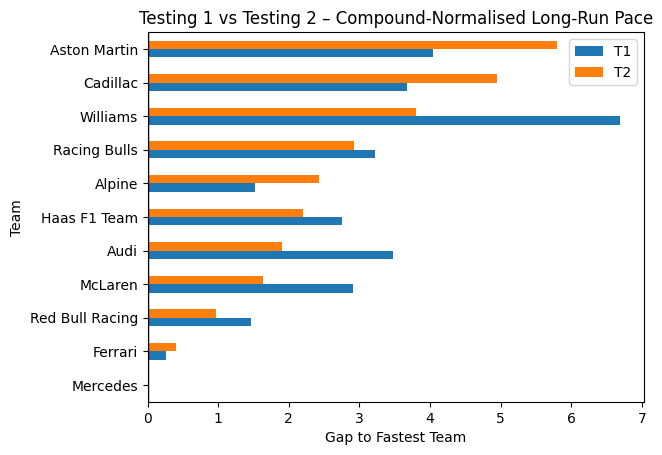

In [35]:
# T1/T2 values are AvgDeltaToBest (compound-normalised gap in seconds)
compare = (
    t1_team_summary[['AvgDeltaToBest']].rename(columns={'AvgDeltaToBest':'T1'})
    .join(t2_team_summary[['AvgDeltaToBest']].rename(columns={'AvgDeltaToBest':'T2'}), how='outer')
)

# Sort by Test 2 (smaller gap = stronger relative pace)
compare = compare.sort_values('T2')

# Horizontal bar chart makes ranking comparisons easier to read
compare.plot(kind='barh')
plt.xlabel("Gap to Fastest Team")
plt.title("Testing 1 vs Testing 2 – Compound-Normalised Long-Run Pace")
plt.axvline(0, color='black', linewidth=1)
plt.show()


## 3. Fastest laps of each driver in both tests

For each driver, their single fastest lap across the whole testing event is picked.
This is a single-lap indicator and is even more sensitive to testing variables (fuel/engine modes), so it’s mainly useful for a descriptive comparison.

In [39]:
def fastest_laps_by_driver(laps, exclude_unknown=True):
    df = laps
    if exclude_unknown and 'Compound' in df.columns:
        # Note: compound labels can vary ('UNKNOWN' vs 'TEST_UNKNOWN') depending on session metadata
        df = df[df['Compound'].notna() & (df['Compound'] != 'UNKNOWN')]
    drivers = pd.unique(df['Driver'])
    fastest_list = []

    for drv in drivers:
        drv_laps = df.pick_drivers(drv)
        if len(drv_laps) == 0:
            continue
        fl = drv_laps.pick_fastest()
        if fl is None or pd.isna(fl.get('LapTime', None)):
            continue
        fastest_list.append(fl)

    fastest = (Laps(fastest_list)
               .sort_values(by='LapTime')
               .reset_index(drop=True))

    return fastest[['Driver', 'Compound', 'LapTime']]

In [37]:
t1_fastest = fastest_laps_by_driver(t1_laps_all)
print(t1_fastest)

   Driver Compound                LapTime
0     ANT     SOFT 0 days 00:01:33.669000
1     RUS     SOFT 0 days 00:01:33.918000
2     HAM     SOFT 0 days 00:01:34.209000
3     LEC     SOFT 0 days 00:01:34.273000
4     NOR   MEDIUM 0 days 00:01:34.669000
5     PIA     SOFT 0 days 00:01:34.721000
6     VER     SOFT 0 days 00:01:34.798000
7     BEA     SOFT 0 days 00:01:35.394000
8     OCO     SOFT 0 days 00:01:35.578000
9     HAD     SOFT 0 days 00:01:35.610000
10    COL     SOFT 0 days 00:01:35.806000
11    HUL     SOFT 0 days 00:01:36.291000
12    BOR     SOFT 0 days 00:01:36.670000
13    GAS     SOFT 0 days 00:01:36.723000
14    ALB     SOFT 0 days 00:01:36.793000
15    LAW     SOFT 0 days 00:01:36.808000
16    BOT     SOFT 0 days 00:01:36.824000
17    SAI   MEDIUM 0 days 00:01:37.186000
18    LIN     SOFT 0 days 00:01:37.470000
19    STR     SOFT 0 days 00:01:38.165000
20    PER     SOFT 0 days 00:01:38.653000
21    ALO   MEDIUM 0 days 00:01:38.960000


In [38]:
t2_fastest = fastest_laps_by_driver(t2_laps_all)
print(t2_fastest)

   Driver      Compound                LapTime
0     LEC        MEDIUM 0 days 00:01:31.992000
1     ANT        MEDIUM 0 days 00:01:32.803000
2     PIA        MEDIUM 0 days 00:01:32.861000
3     NOR        MEDIUM 0 days 00:01:32.871000
4     VER  TEST_UNKNOWN 0 days 00:01:33.109000
5     RUS  TEST_UNKNOWN 0 days 00:01:33.197000
6     HAM        MEDIUM 0 days 00:01:33.408000
7     GAS          SOFT 0 days 00:01:33.421000
8     BEA        MEDIUM 0 days 00:01:33.487000
9     BOR        MEDIUM 0 days 00:01:33.755000
10    COL          SOFT 0 days 00:01:33.818000
11    HUL        MEDIUM 0 days 00:01:33.987000
12    LIN        MEDIUM 0 days 00:01:34.149000
13    OCO        MEDIUM 0 days 00:01:34.201000
14    HAD        MEDIUM 0 days 00:01:34.260000
15    SAI          SOFT 0 days 00:01:34.342000
16    LAW        MEDIUM 0 days 00:01:34.532000
17    ALB          SOFT 0 days 00:01:34.555000
18    BOT        MEDIUM 0 days 00:01:35.304000
19    PER          SOFT 0 days 00:01:35.369000
20    STR    

Compare fastest lap times for drivers present in both tests and visualised as a "dumbbell"/connected-dot chart:

In [40]:
cmp = (t1_fastest.set_index('Driver')[['LapTime']].rename(columns={'LapTime':'T1'})
       .join(t2_fastest.set_index('Driver')[['LapTime']].rename(columns={'LapTime':'T2'}),
             how='inner')
      )
cmp.head()

,T1,T2
Driver,,
ANT,0 days 00:01:33.669000,0 days 00:01:32.803000
RUS,0 days 00:01:33.918000,0 days 00:01:33.197000
HAM,0 days 00:01:34.209000,0 days 00:01:33.408000
LEC,0 days 00:01:34.273000,0 days 00:01:31.992000
NOR,0 days 00:01:34.669000,0 days 00:01:32.871000


In [41]:
cmp['T1_sec'] = cmp['T1'].dt.total_seconds()
cmp['T2_sec'] = cmp['T2'].dt.total_seconds()

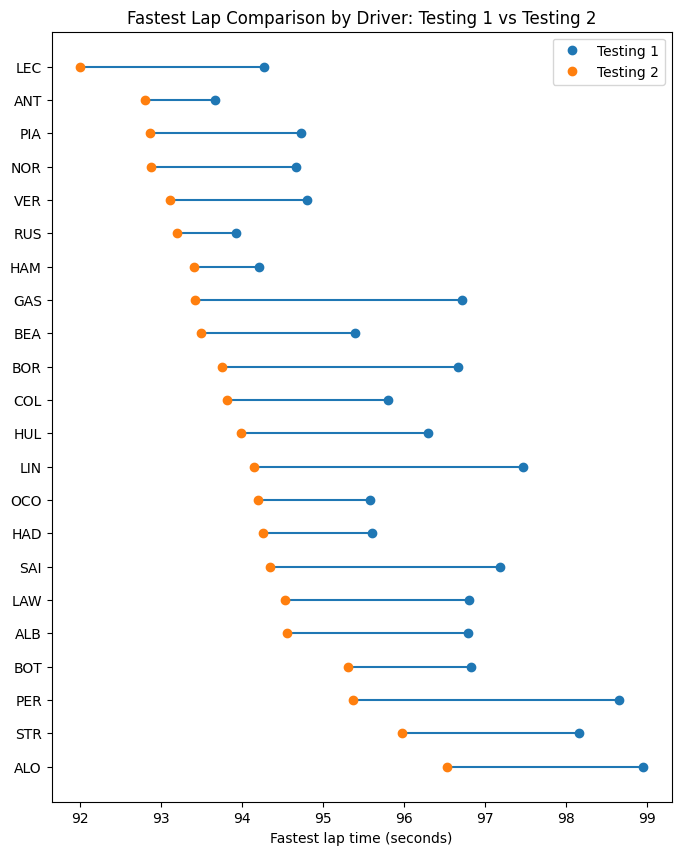

In [46]:
cmp = cmp.sort_values('T2_sec')
y = np.arange(len(cmp))
plt.figure(figsize=(8, 10))

# Lines between T1 and T2 for each driver
plt.hlines(y, cmp['T1_sec'], cmp['T2_sec'])

# Points for T1 and T2
plt.plot(cmp['T1_sec'], y, 'o', label='Testing 1')
plt.plot(cmp['T2_sec'], y, 'o', label='Testing 2')

plt.yticks(y, cmp.index)
plt.xlabel("Fastest lap time (seconds)")
plt.title("Fastest Lap Comparison by Driver: Testing 1 vs Testing 2")
plt.legend()

# Put fastest at the top
plt.gca().invert_yaxis()

plt.show()

## 4. Team mileage comparisons

Mileage proxy: total number of recorded laps per team (not distance-corrected, but OK since same circuit)

This shows which teams completed the most running across the two events.

In [47]:
t1_team_laps = t1_laps_all.groupby('Team').size().rename('T1_Laps')
t2_team_laps = t2_laps_all.groupby('Team').size().rename('T2_Laps')

mileage = pd.concat([t1_team_laps, t2_team_laps], axis=1).fillna(0).astype(int)
mileage['Total_Laps'] = mileage['T1_Laps'] + mileage['T2_Laps']

mileage.sort_values('Total_Laps', ascending=False)

,T1_Laps,T2_Laps,Total_Laps
Team,,,
McLaren,380,392,772
Haas F1 Team,364,396,760
Williams,383,359,742
Racing Bulls,302,391,693
Ferrari,368,310,678
Audi,318,349,667
Mercedes,238,419,657
Alpine,304,344,648
Red Bull Racing,313,329,642


In [49]:
# Example deep-dive: session-by-session lap counts and max lap number for Mercedes
# (quick sanity check that we loaded all days and the lap indexing looks reasonable)
t1_laps_all[t1_laps_all['Team']=='Mercedes'].groupby('Session').size()
t2_laps_all[t2_laps_all['Team']=='Mercedes'].groupby('Session').size()

t1_laps_all[t1_laps_all['Team']=='Mercedes'].groupby('Session')['LapNumber'].max()
t2_laps_all[t2_laps_all['Team']=='Mercedes'].groupby('Session')['LapNumber'].max()

Session
1    75.0
2    79.0
3    82.0
Name: LapNumber, dtype: float64

In [51]:
# To verify team labels are present and consistent (useful if plotting/grouping looks off)
len(t1_laps_all), len(t2_laps_all), len(t1_laps_all) + len(t2_laps_all)

(3456, 3681, 7137)

In [19]:
print(t1_laps_all['Team'])

0            McLaren
1            McLaren
2            McLaren
3            McLaren
4            McLaren
            ...     
3451    Haas F1 Team
3452    Haas F1 Team
3453    Haas F1 Team
3454    Haas F1 Team
3455    Haas F1 Team
Name: Team, Length: 3456, dtype: object


In [20]:
print(t2_laps_all['Team'])

0            McLaren
1            McLaren
2            McLaren
3            McLaren
4            McLaren
            ...     
3676    Haas F1 Team
3677    Haas F1 Team
3678    Haas F1 Team
3679    Haas F1 Team
3680    Haas F1 Team
Name: Team, Length: 3681, dtype: object


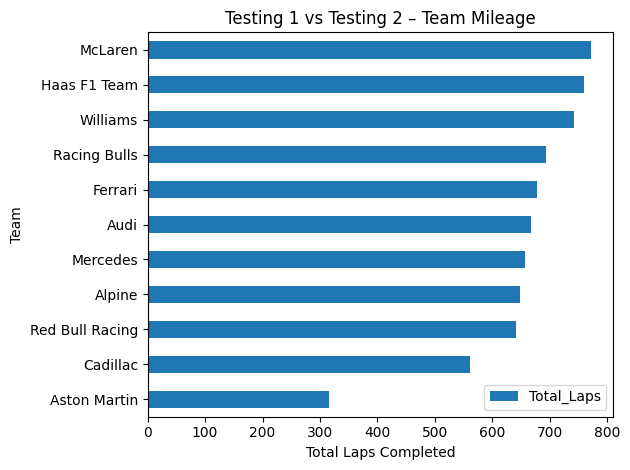

In [53]:
# Visualise total laps (T1+T2) per team
# Higher mileage usually means more completed program, but not necessarily more pace.
laps_sorted = mileage.sort_values("Total_Laps")

laps_sorted[["Total_Laps"]].plot(
    kind="barh",
)

plt.xlabel("Total Laps Completed")
plt.title("Testing 1 vs Testing 2 – Team Mileage")
plt.tight_layout()
plt.show()

## 5. Limitations
Because of unknown fuel loads, engine modes, and program objectives, testing pace cannot be directly compared.

In this context, "long runs" are deduced from continuous lap sequences, which may or may not be actual race simulations.

Although normalising within a compound lessens tyre impacts, the compounds each team ran and the amount of data we detected still affect the outcomes.

While track status filtering ("1") eliminates laps that are not representative, it may also leave out meaningful running under various circumstances.

## 6. Conclusion
There doesn't seem to be much of a difference between the teams in performance, indicating a strong and exciting early benchmark. The fact that compound-normalized long-run deltas are still closely clustered suggests that several teams may be working inside a constrained performance window.

These findings should be viewed as early indicators rather than definitive forecasts due to the inherent unpredictability of testing procedures. The competitive order is still in flux, and it won't be evident until the season starts how these margins transfer in actual race conditions.